# **Titanic - Machine Learning from Disaster**


# Table of Contents

* [1: Modules](#Modules)
* [2: Preparing Data](#PreparingData)
    * [2.1: Read Data](#ReadData)
    * [2.2: Missed Data Status](#MissedDataStatus)
    * [2.3: Data Labeling](#DataLabeling)
    * [2.3: Data Visualization](#DataVisualization)
    * [2.3: Imputer Design](#ImputerDesign)
    * [2.3: Encoder Design](#EncoderDesign)
    * [2.3: Drop Useless Features](#DropUselessFeatures)
* [3: Dimensionality Reduction](#DimensionalityReduction)
    * [3.1: Sensitivity Analysis](#SensitivityAnalysis)
        * [3.2: Decide on effective features](#DecideonEffectiveFeatures)
    * [3.3: UMAP Algorithm](#UMAPAlgorithm)
    
* [4: Machine Learning Design](#MachineLearning)
    * [4.1: Scaling](#Scaling)
    * [4.2: Cross Validation Prediction](#CrossValidationPrediction)
    * [4.3: Tuning Hyper Parameters](#TuningHyperParameters)
    * [4.4: Prediction](#Prediction)
    


<a class="anchor" id="Modules"></a>
### **Modules** 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import math
from sklearn import svm, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB,CategoricalNB,BernoulliNB,ComplementNB
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


### **Preparing Data** 
<a class="anchor" id="PreparingData"></a>


<a class="anchor" id="ReadData"></a>
#### **Read Data** 

In [2]:
# mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
tdata = pd.read_csv('/kaggle/input/titanic/test.csv')
mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
mdata.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<a class="anchor" id="MissedDataStatus"></a>
#### **Missed Data Status** 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

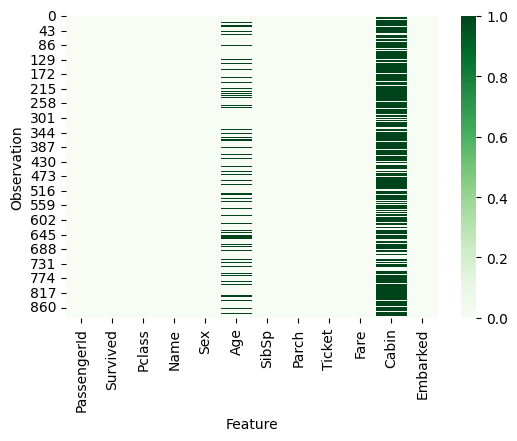

In [4]:
plt.figure(dpi=100)
sns.heatmap(mdata.isnull(), cmap="Greens")
plt.xlabel('Feature')
plt.ylabel('Observation')
mdata.isnull().sum()

<a class="anchor" id="ImputerDesign"></a>
#### **Imputer Design**

In [5]:
# mean_age_men=mdata[mdata['Sex']=="male"]['Age'].mean()
# mean_age_women=mdata[mdata['Sex']=="female"]['Age'].mean()
# mdata.loc[(mdata.Age.isnull()) & (mdata['Sex']=="female"),'Age']=mean_age_women
# mdata.loc[(mdata.Age.isnull()) & (mdata['Sex']=="male"),'Age']=mean_age_men

# mean_age_men=tdata[tdata['Sex']=="male"]['Age'].mean()
# mean_age_women=tdata[tdata['Sex']=="female"]['Age'].mean()
# tdata.loc[(tdata.Age.isnull()) & (tdata['Sex']=="female"),'Age']=mean_age_women
# tdata.loc[(tdata.Age.isnull()) & (tdata['Sex']=="male"),'Age']=mean_age_men

<a class="anchor" id="DataLabeling"></a>
#### **Data Labeling**

In [6]:
def data_cleaner(data):
    data["Title"] = data["Name"].apply(lambda x: x[x.find(',') : x.find('.')][1:].strip())
    data["Title"] = data["Title"].apply(lambda x: 'Mr' if x == 'Mr' else x) # Mr
    data["Title"] = data["Title"].apply(lambda x: 'Miss' if x == 'Ms'or x == 'Mme' or x=='Mlle' else x) #Miss
    data["Title"] = data["Title"].apply(lambda x: 'Mrs' if x == 'Mrs' else x) #Mrs
    data["Title"] = data["Title"].apply(lambda x: 'Master' if x == 'Master' else x) #Master
    data["Title"] = data["Title"].apply(lambda x: 'Others' if x != 'Mr' and x != 'Miss' and x!= 'Mrs' and x!= 'Master' else x)

    data["Age_group"] = data["Age"].apply( lambda x: 'KIDs' if math.isnan(x)==False and x<=10 else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'TEENs' if (type(x)!=str and math.isnan(x)==False and x<=20 and x >10) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'YOUNGs' if (type(x)!=str and math.isnan(x)==False and x<=40 and x >20) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'OLDs' if (type(x)!=str and math.isnan(x)==False and x >40) else x)
    
    data["FamSize"] = data["SibSp"]+data["Parch"]
    data["FamSizeLabel"] = data["FamSize"].apply( lambda x: 'Small' if int(x)<=2 else 'Large')

    data["FareInter"] = data["Fare"].apply(   
        lambda x: 'LowFare' if x<=7.910400 else ('MidFar' if float(x)>=7.910400 and float(x)<=14.454200 else "HighFare"))
                                  

    return data

data_cleaner(mdata)
data_cleaner(tdata)
mdata.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


<a class="anchor" id="DataVisualization"></a>
#### **Data Visualization**

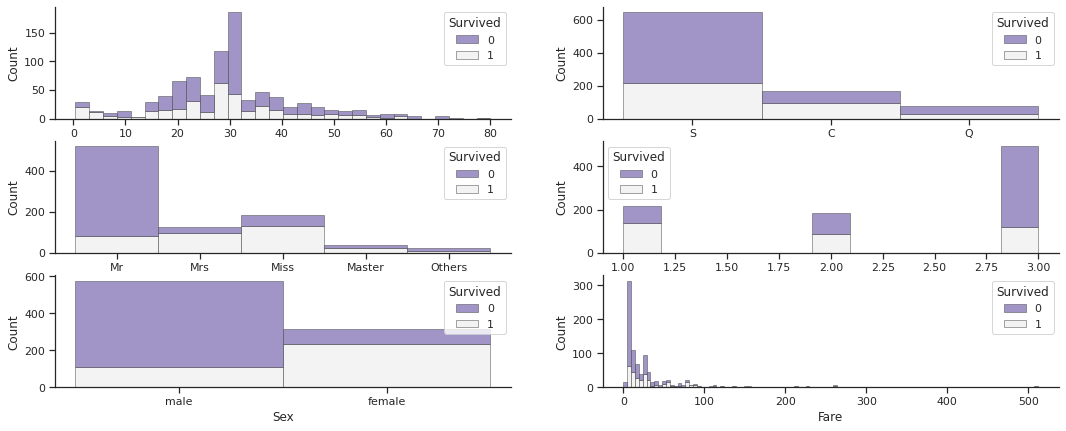

In [7]:
xcol = ["Age","Title", "Sex","Embarked", "Pclass","Fare" ]
huecol = "Survived"
r = 3
c = 2
def mybar(data, xcol, huecol, r, c):
    i = -1
    sns.set_theme(style="ticks")
    f, ax = plt.subplots(r,c,figsize=(18, 7))
    sns.despine(f)
    for col in xcol:
        i+=1
        y = lambda y: int(0) if y<3 else int(1)
        x = lambda x: x if x<3 else int(x-3)
        sns.histplot( data, x=col, hue=huecol, multiple="stack", palette="light:m_r",
            edgecolor=".3", linewidth=.5, log_scale=False,ax = ax[x(i), y(i)])
mybar(mdata, xcol, huecol, r, c)


<a class="anchor" id="EncoderDesign"></a>
#### **Encoder Design**

In [8]:
# Encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
def titanic_encoder(data):
#     enc.fit(data[["Embarked"]])
#     data[["S","Q","C"]] = \
#         pd.DataFrame(enc.transform(data[["Embarked"]]).toarray())
    #----
    enc.fit(data[["Sex"]])
    data[["F","M"]] = \
        pd.DataFrame(enc.transform(data[["Sex"]]).toarray())
    #----
#     enc.fit(data[["Age_group"]])
#     data[["A1","A2","A3","A4"]] = \
#         pd.DataFrame(enc.transform(data[["Age_group"]]).toarray())
    #----
#     enc.fit(mdata[["FamSizeLabel"]])
#     data[["Fam1","Fam2"]] = \
#         pd.DataFrame(enc.transform(data[["FamSizeLabel"]]).toarray())
    #----
#     enc.fit(mdata[["Pclass"]])
#     data[["C1","C2","C3"]] = \
#         pd.DataFrame(enc.transform(data[["Pclass"]]).toarray())
    #----
#     enc.fit(mdata[["FareInter"]])
#     data[["F1","F2","F3"]] = \
#         pd.DataFrame(enc.transform(data[["FareInter"]]).toarray())
    return data
# titanic_encoder(mdata)
# titanic_encoder(tdata)
# mdata.Age = (mdata.Age-min(mdata.Age))/(max(mdata.Age)-min(mdata.Age))
# mdata.Fare = (mdata.Fare-min(mdata.Fare))/(max(mdata.Fare)-min(mdata.Fare))
# tdata.Age = (tdata.Age-min(tdata.Age))/(max(tdata.Age)-min(tdata.Age))
# tdata.Fare = (tdata.Fare-min(tdata.Fare))/(max(tdata.Fare)-min(tdata.Fare))
mdata.Sex=mdata.Sex.map({'female':0, 'male':1})
tdata.Sex=tdata.Sex.map({'female':0, 'male':1})
mdata.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr


<a class="anchor" id="DropUselessFeatures"></a>
#### **Drop Useless Features**
There are some useless columns like "Name", "Cabin" that their information does not contribute in making a model. Moreover those columns whose data are encoded to binaries are also removed. Because I am going to work with the binary data. 

In [9]:
col = ["PassengerId","Name","Cabin","Ticket",'Fare']
mdata_drp = mdata.drop(col,axis = 1)
tdata_drp = tdata.drop(col,axis = 1)


<a class="anchor" id="DimensionalityReduction"></a>
## **Dimensionality Reduction**

<a class="anchor" id="SensitivityAnalysis"></a>
#### **Sensitivity Analysis**

Text(0.0, 1.0, 'A')

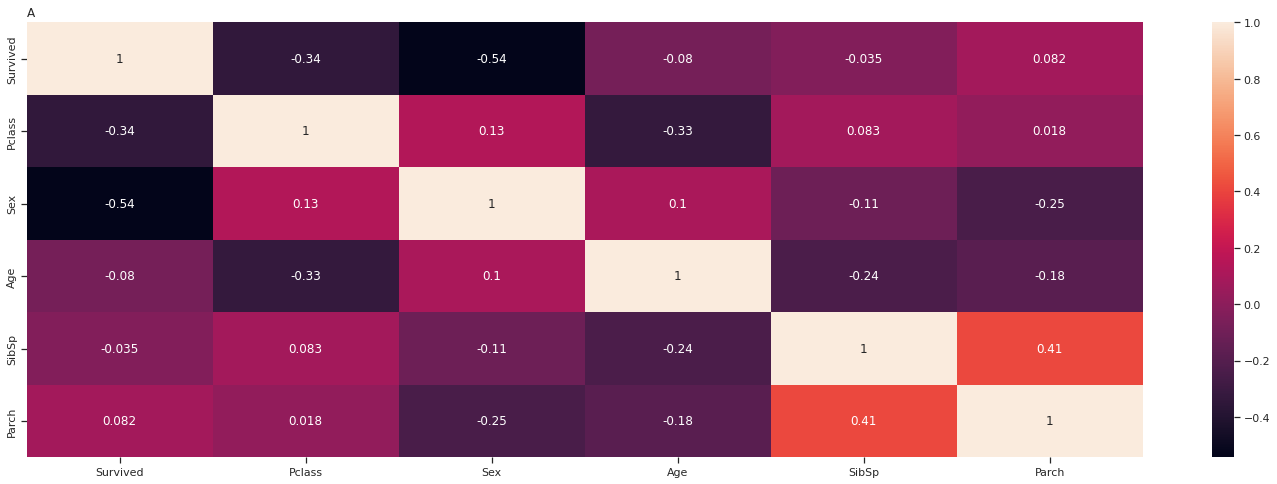

In [10]:
myheatmap=plt.figure(figsize=(25,8))
sns.heatmap(mdata_drp.corr(),annot=True)
plt.title("A",loc='left')

<a class="anchor" id="DecideonEffectiveFeatures"></a>
#### **Decide on Effective Features**

In [11]:
var_col =  ["Pclass","Age","SibSp","Parch","Sex"]
fit_col = "Survived"

<a class="anchor" id="UMAPAlgorithm"></a>
#### **UMAP Algorithm**
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

In [12]:
# import umap
# trans = umap.UMAP(n_neighbors=50, random_state=3, min_dist=0.3,
#                       metric='correlation').fit(mdata_drp[var_col])
# plt.figure(figsize = (10,5))
# plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 10, c=[sns.color_palette()[x] for x in mdata_drp[fit_col]])
# plt.xlabel("Dim1")
# plt.ylabel("Dim2")

<a class="anchor" id="UMAPAlgorithm"></a>
#### **PCA Algorithm**

In [13]:
# pca = PCA(n_components=10)
# red_x = pca.fit_transform(mdata_drp[var_col])
# scaler= StandardScaler()
# red_x_std = scaler.fit_transform(red_x)
scaler = MinMaxScaler()
x_std = scaler.fit_transform(mdata_drp[var_col])

Note: UMAP has no good space reduction and the boundaries are not clear. So, I used only sensitivity analysis to drop less effective parameter.

<a class="anchor" id="MachineLearning"></a>
## **Machine Learning**

<a class="anchor" id="Scaling"></a>
#### **Split Data**
Note: All features have been encoded between 0 and 1, so the scaling data has not been employed here.

In [14]:
y = mdata_drp[fit_col].values
y=np.reshape(y,(len(y),))
x_train, x_test, y_train, y_test = train_test_split(x_std, y,
                                                    train_size=0.85,
                                                    random_state=0)


<a class="anchor" id="CrossValidationPrediction"></a>
#### **Cross Validation Prediction**
Note: I am evaluating four different classification mehods.

In [15]:
estimators = [svm.SVC(),
              ensemble.RandomForestClassifier(),
              KNeighborsClassifier(), SGDClassifier(),LogisticRegression()]

for esti in estimators:
    y_pred = cross_val_predict(esti,x_train,y_train,cv=3)
    print(f"\nClassification Report for {esti}:")
    print("Accuracy= ", accuracy_score(y_pred, y_train))
    print(confusion_matrix(y_pred, y_train))
    print(classification_report(y_pred,y_train))
        


Classification Report for SVC():
Accuracy=  0.7873183619550859
[[420 111]
 [ 50 176]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       531
           1       0.61      0.78      0.69       226

    accuracy                           0.79       757
   macro avg       0.75      0.78      0.76       757
weighted avg       0.81      0.79      0.79       757


Classification Report for RandomForestClassifier():
Accuracy=  0.7846763540290621
[[389  82]
 [ 81 205]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       471
           1       0.71      0.72      0.72       286

    accuracy                           0.78       757
   macro avg       0.77      0.77      0.77       757
weighted avg       0.78      0.78      0.78       757


Classification Report for KNeighborsClassifier():
Accuracy=  0.8071334214002642
[[416  92]
 [ 54 195]]
              precision    recall  f1-score   sup

<a class="anchor" id="TuningHyperParameters"></a>
#### **Tuning Hyper Parameters**

In [16]:
# Parameters of random support vector machine

kernel=['poly','rbf','sigmoid']
C= [1,5,10,20,50,100,200,500,1000]
degree = [1,2,3,4]
gamma = ['scale', 'auto']
distributions = {
    "kernel": kernel,
    "C": C,
    "degree":degree,
    "gamma" : gamma,
}

iestimator = RandomizedSearchCV(
    svm.SVC(),
    param_distributions=distributions,
    n_iter = 30
)

iestimator_dict = iestimator.fit(x_train,y_train)
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_train))
print(confusion_matrix(best_y_pred, y_train))
print(classification_report(best_y_pred,y_train))

Accuracy=  0.8150594451783355
[[421  91]
 [ 49 196]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       512
           1       0.68      0.80      0.74       245

    accuracy                           0.82       757
   macro avg       0.79      0.81      0.80       757
weighted avg       0.83      0.82      0.82       757



In [20]:
# Parameters of random forest

n_estimators= [50,100,500]
criterion = ["gini", "entrop", "log_loss"]
max_depth = [10,50,100]
min_samples_split = [5,10,20,40]
min_samples_leaf = [5,10,20,40]
max_features = ["sqrt","log2"]
distributions = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_depth":max_depth,
    "min_samples_split" : min_samples_split,
    "min_samples_leaf"  : min_samples_leaf,
    "max_features":max_features,
    
}

iestimator = RandomizedSearchCV(
    ensemble.RandomForestClassifier(),
    param_distributions=distributions,
    n_iter = 30
)

iestimator_dict = iestimator.fit(x_train,y_train)
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_train))
print(confusion_matrix(best_y_pred, y_train))
print(classification_report(best_y_pred,y_train))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
85 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/par

Accuracy=  0.8269484808454426
[[425  86]
 [ 45 201]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       511
           1       0.70      0.82      0.75       246

    accuracy                           0.83       757
   macro avg       0.80      0.82      0.81       757
weighted avg       0.84      0.83      0.83       757



<a class="anchor" id="Prediction"></a>
#### **Prediction**

In [21]:
tdata_final = pd.DataFrame([tdata['PassengerId'],best_config.predict(tdata_drp[var_col])],index = ['PassengerId','Survived']).T
tdata_final.to_csv('./result.csv')

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [22]:
tdata_final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0
